In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import copy
import yaml

In [2]:
from workers.utils.misc import save_yaml, timestamp

In [3]:
def load_yaml(path):
    with open(path, mode='r') as file:
        return yaml.load(file, Loader=yaml.FullLoader)

In [4]:
def generate_nodes(iot_count, edge_count, verifier_count, storage_count, grid_size):
    
    # NODE CONTAINER
    nodes = {
        'service': [],
        'verifier': [],
        'storage': [],
        'edge': [],
        'iot': [],
    }
    
    # RANDOM COORD GENERATION
    smallest = 0+0.5
    largest = grid_size-0.5
    
    generate_node = lambda x: {
        'name': x,
        'location': {
            'x': np.random.uniform(smallest, largest),
            'y': np.random.uniform(smallest, largest),
        }
    }
    
    # CREATE SERVICE NODE
    nodes['service'].append(generate_node('service'))
    
    # CREATE VERIFIERS
    for index in range(verifier_count):
        name = 'verifier-{}'.format(index+1)
        nodes['verifier'].append(generate_node(name))
    
    # CREATE STORAGE NODES
    for index in range(storage_count):
        name = 'storage-{}'.format(index+1)
        nodes['storage'].append(generate_node(name))
    
    # CREATE EDGES
    for index in range(edge_count):
        name = 'edge-{}'.format(index+1)
        nodes['edge'].append(generate_node(name))
    
    # CREATE IOT NODES
    for index in range(iot_count):
        name = 'iot-{}'.format(index+1)
        nodes['iot'].append(generate_node(name))
    
    # TIMESTAMP
    now = int(timestamp())
    filename = 'workers/networks/{}.yml'.format(now)
    
    # SAVE IT
    save_yaml(filename, {
        'config': {
            'iots': iot_count,
            'edges': edge_count,
            'verifiers': verifier_count,
            'storages': storage_count,
            'grid_size': grid_size
        },
        'nodes': nodes
    })
    
    return nodes

In [5]:
def containerize(nodes):
    xs, ys, colors, sizes = [], [], [], []
    
    col_refs = {
        'iot': '#e75f5b',
        'edge': '#3378ca',
        'service': '#928478',
        'verifier': '#52af52',
        'storage': '#b896c6'
    }
    
    node_sizes = {
        'iot': 50,
        'edge': 200,
        'storage': 100,
        'service': 400,
        'verifier': 100,
    }
    
    label_offset = {
        'iot': 0.13,
        'edge': 0.2,
        'service': 0.27,
        'verifier': 0.17,
        'storage': 0.17
    }
    
    # LOOP THROUGH
    for node in nodes['service']:
        xs.append(node['location']['x'])
        ys.append(node['location']['y'])
        colors.append(col_refs['service'])
        sizes.append(node_sizes['service'])
        
    # LOOP THROUGH
    for node in nodes['verifier']:
        xs.append(node['location']['x'])
        ys.append(node['location']['y'])
        colors.append(col_refs['verifier'])
        sizes.append(node_sizes['verifier'])
        
    # LOOP THROUGH
    for node in nodes['storage']:
        xs.append(node['location']['x'])
        ys.append(node['location']['y'])
        colors.append(col_refs['storage'])
        sizes.append(node_sizes['storage'])
        
    # LOOP THROUGH
    for node in nodes['edge']:
        xs.append(node['location']['x'])
        ys.append(node['location']['y'])
        colors.append(col_refs['edge'])
        sizes.append(node_sizes['edge'])
        
    # LOOP THROUGH
    for node in nodes['iot']:
        xs.append(node['location']['x'])
        ys.append(node['location']['y'])
        colors.append(col_refs['iot'])
        sizes.append(node_sizes['iot'])
        
    return xs, ys, colors, sizes, label_offset, col_refs

In [6]:
def find_closest(target, nodes):
    best_node = None
    best_distance = float('inf')

    # NO EDGES EXIST
    if len(nodes) == 0:
        return best_node

    # FIND THE CLOSEST
    for node in nodes:

        # COMPUTE STRAIGHT LINE DISTANCE
        P1 = abs(target['location']['x'] - node['location']['x'])**2
        P2 = abs(target['location']['y'] - node['location']['y'])**2
        distance = math.sqrt(P1 + P2)

        # UPDATE WHEN A BETTER DISTANCE IS FOUND
        if distance < best_distance:
            best_node = node
            best_distance = distance

    return best_node

In [7]:
def compute_connections(nodes):
    connections = []
    
    # CONNECT EVERY VERIFIER WITH EVERY SERVICE
    for verifier in nodes['verifier']:
        for service in nodes['service']:
            connections.append({
                'x': [verifier['location']['x'], service['location']['x']],
                'y': [verifier['location']['y'], service['location']['y']],
                'type': 'verifier'
            })
    
    # CONNECT EVERY IOT WITH THE CLOSEST EDGE
    for iot in nodes['iot']:
        closest = find_closest(iot, nodes['edge']) 
        
        connections.append({
            'x': [iot['location']['x'], closest['location']['x']],
            'y': [iot['location']['y'], closest['location']['y']],
            'type': 'iot'
        })
    
    # CONNECT EDGES TO CLOSEST STORAGE
    for edge in nodes['edge']:
        closest = find_closest(edge, nodes['storage']) 
        
        connections.append({
            'x': [edge['location']['x'], closest['location']['x']],
            'y': [edge['location']['y'], closest['location']['y']],
            'type': 'edge'
        })
            
    return connections

In [58]:
def draw_graph(params={}, filename=None, create_pdf=False):
    nodes = None
    grid_size = None
    
    # IF A FILENAME WAS PASSED, LOAD DATASET
    if filename:
        path = 'workers/networks/{}.yml'.format(filename)
        dataset = load_yaml(path)
        nodes = dataset['nodes']
        grid_size = dataset['config']['grid_size']
        
    # OTHERWISE, GENERATE ONE
    else:
        nodes = generate_nodes(**params)
        grid_size = params['grid_size']
    
    connections = compute_connections(nodes)
    xs, ys, colors, sizes, offsets, col_refs = containerize(nodes)
    
    # SETTINGS
    line_opacity = 0.5
    line_width = 1
    
    # CREATE FIGURE
    fig, ax = plt.subplots(figsize=(grid_size, grid_size), dpi=100)
    
    # DRAW DOTS
    ax.scatter(xs, ys, s=sizes, c=colors, alpha=0.95, zorder=10, vmin=0, vmax=100)
    
    # DRAW LINES
    for connection in connections:
        ax.plot(
            connection['x'],
            connection['y'],
            '-',
            color=col_refs[connection['type']],
            linewidth=line_width,
            alpha=line_opacity
        )
    
    # ADD ANNOTATIONS
    for key in nodes:
        for node in nodes[key]:
            ax.annotate(
                node['name'].upper(),
                (node['location']['x'], node['location']['y'] + offsets[key]),
                ha='center'
            )
            
            ax.plot(
                [node['location']['x'], nodes['service'][0]['location']['x']],
                [node['location']['y'], nodes['service'][0]['location']['y']],
                '-',
                color=col_refs['service'],
                linewidth=line_width,
                alpha=0.1
            )

    # SET LIMITS
    ax.set(
        xlim=(0, grid_size), xticks=np.arange(0, grid_size),
        ylim=(0, grid_size), yticks=np.arange(0, grid_size)
    )

    # SET GRID
    plt.grid(linewidth=0.5, alpha=0.2)
    
    # CREATE PDF WHEN REQUESTED
    if create_pdf:
        temp = int(timestamp())
        pdf_path = 'workers/networks/{}.pdf'.format(temp)
        plt.savefig(pdf_path)
    
    # RENDER GRAPH
    plt.show()

In [59]:
params = {
    'verifier_count': 3,
    'storage_count': 3,
    'edge_count': 5,
    'iot_count': 20,
    'grid_size': 10
}

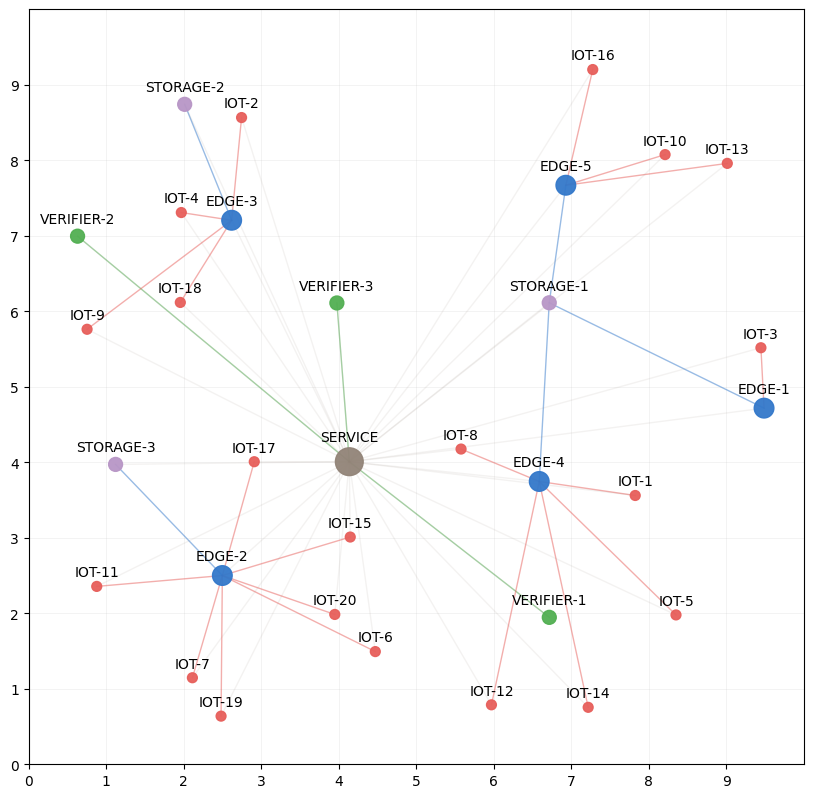

In [67]:
draw_graph(
    filename='good-example',
)